# Riconoscimento di un volto tramite modello Eigenface

Dato un dataset di volti vogliamo allenare un modello che, fornito un campione non presente nei dati di training, ci definisca se il campione è o meno un volto di una persona già analizzata.

In [1]:
from sklearn.datasets import fetch_olivetti_faces

X, y = fetch_olivetti_faces(data_home='Data', shuffle=True, random_state=42, return_X_y=True)

Le facce per essere analizzate dal modello eigenface devono essere in scala di grigi e versorizzate. Un'immagine in scala di grigi sarà modellata come una matrice $M \in \mathbb{R}^{mxn}$ con $m_{ij} \in [0, 255]$ $(i = 1, \dots, m \ e j = 1, \dots, n)$. Un successivo step è quello della normalizzazione dei dati, possiamo dividere tutto per 255 ed ottenere che i vari $m_{ij} \in [0, 1]$. Questo step non è fondamentale ma potrebbe aiutare con le performance. Per quanto riguarda la versorizzazione dei volti, vogliamo banalmente mettere le varie colonne della matrice in una singola colonna, ottenendo: $M \in \mathbb{R}^{mnx1}$. Così facendo abbiamo ottenuto il primo volto del nostro modello, dobbiamo chiaramente fare lo stesso passaggio per tutti i volti del dataset, ottenendo un dataset in forma $M \in \mathbb{R}^{mnxp}$, dove $p$ rappresenta il numero di campioni (facce). Fortunatamente il dataset Olivetti è già in questa forma.

Suddividiamo il dataset in train e test, con una percentuale di suddivisione pari a 70% / 30%.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

Mostriamo delle facce all'interno del training set.

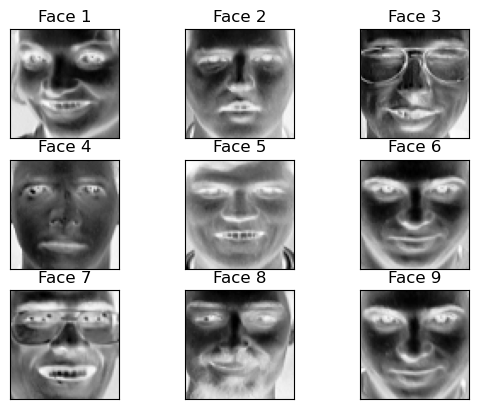

In [3]:
import pylab as plt
import numpy as np

fig, axs = plt.subplots(3, 3)

k=0
for i in range(0, 3):
    for j in range(0, 3):
        k+=1
        axs[i, j].imshow(X_train[k, :].reshape(64, 64), cmap='Greys')
        axs[i, j].set_title('Face ' + str(k))
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

Il modello eigenfaces si basa sul concetto di PCA, in entrambi i casi vogliamo ottenere un "dataset risultato" completamente scorrelato e che ci permetta di definire uno spazio latente. Per fare ciò abbiamo bisogno, nel caso specifico di eigenfaces, di calcolare la "media delle facce", ossia una sorta di faccia generica di un essere umano, che rappresenta tutti i dettagli che ogni faccia dovrebbe avere.

Text(0.5, 1.0, 'Media delle facce')

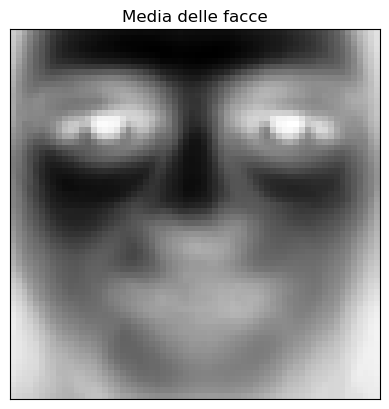

In [4]:
mean_face = np.average(X_train, axis=0)

im, ax1 = plt.subplots(1,1)
fig = ax1.imshow(mean_face.reshape(64, 64), cmap='Greys')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
ax1.set_title("Media delle facce")

Mostriamo per completezza un esempio di faccia centrata sulla media.

[]

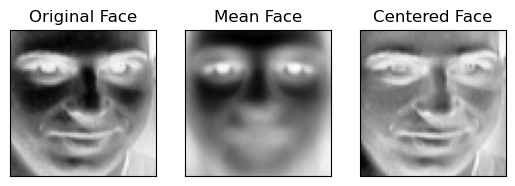

In [5]:
fig, axs = plt.subplots(1, 3)

axs[0].imshow(X_train[0].reshape(64, 64), cmap='Greys')
axs[0].set_title('Original Face')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(mean_face.reshape(64, 64), cmap='Greys')
axs[1].set_title('Mean Face')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow((X_train[0] - mean_face).reshape(64, 64), cmap='Greys')
axs[2].set_title('Centered Face')
axs[2].set_xticks([])
axs[2].set_yticks([])

Utilizzando la fattorizzazione SVD siamo in grado di rimodellare la base sulla quale è definita la matrice dei dati, definendo uno spazio latente, che chiameremo spazio delle facce.

Dopo aver generato il nostro spazio latente il passaggio successivo è quello di calcolare un vettore $\Omega_k = {\omega_1, \dots, \omega_k}$ che rappresenta il peso di ogni eigenface per la ricostruzione della k-esima faccia. Quindi per ogni faccia facente parte del dataset di training, calcoleremo un vettore di pesi che ci servirà dopo per fare inferenza sul modello.

In [6]:
import scipy.linalg as las

def get_omega(face, mean_face, eigenfaces):
    omega = []
    for k in range(len(eigenfaces[0])):
        omega.append(eigenfaces[:, k].T @ (face - mean_face))
    
    return omega


def train_eigenfaces(X, mu=0.75):
    #Calculate mean face
    mean_face = np.average(X, axis=0)
    
    #Center the dataset
    X_c = X

    for i in range(len(X_train)):
        X_c[i, :] = X[i, :] - mean_face
    
    #Calculate eigenvectors
    U, S, V = las.svd(X_c)
    
    #Calculate cumulative variance
    cum_sum = np.cumsum(S) / np.sum(S)
    M = next(i for i in range(len(cum_sum)) if cum_sum[i] >= mu)
    eigenfaces = V.T[:, :M]
    
    #Pre-calculate the weights for future inferece
    omega_k = []
    
    for k in range(len(X_c)):
        omega_k.append(get_omega(X_c[k, :], mean_face, eigenfaces))
    
    return eigenfaces, mean_face, omega_k 

eigenfaces, mean_face, omega_k = train_eigenfaces(X_train)

Mostriamo alcune di queste eigenfaces per vedere effettivamente i risultati dell'algoritmo.

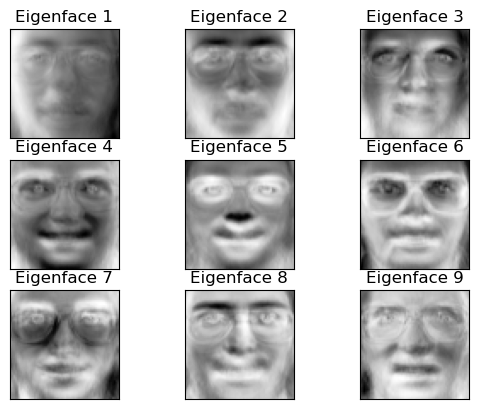

In [7]:
fig, axs = plt.subplots(3, 3)

k=0
for i in range(0, 3):
    for j in range(0, 3):
        k+=1
        axs[i, j].imshow(eigenfaces[:, k].reshape(64, 64), cmap='Greys')
        axs[i, j].set_title('Eigenface ' + str(k))
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

Dopo aver definito la fase di training, vogliamo fare inferenza sul nostro modello allenato. Data una faccia (chiaramente versorizzata e in scala di grigi), essa viene centrata sulla base della faccia media calcolata durante l'allenamento. Dopo aver fatto ciò calcoliamo il vettore $\Omega$ relativo alla faccia da dover identificare. Per stabilire quale delle k facce di train sia la pù vicina alla faccia data in input calcoliamo la distanza della faccia dalle altre: \
$e_k^2 = ||\Omega - \Omega_k||_2^2$

Ovviamente di questi risultati ci interessa solo la k-esima faccia più vicina, quella che possiamo definire la più simile. Possiamo accettare questo valore in modo diretto? In questo caso no, perchè non abbiamo modo di definire se il volto definito sia effettivamente facente parte del dataset di train. Per fare ciò definiamo un valore soglia $\tau$ che servirà da nostro valore di threshold per definire se i due volti sono abbastanza simili.

Ora sappiamo quale delle facce di train rappresenta al meglio il nostro nuovo campione, ma come facciamo a stabilire se effettivamente l'immagine in input è o meno un volto? Per fare ciò abbiamo bisogno di definire la distanza dell'immagine portata in esame dallo spazio delle facce stesso. Se l'immagine sarà troppo lontana, possiamo dire con certezza che essa sarà un qualcosa di molto lontano da un volto, se essa invece sarà molto vicina allora possiamo dire che essa sarà un volto. Per fare ciò dobbiamo definire le proiezioni nello spazio delle facce, come facciamo? Definiamo la distanza dell'immagine dallo spazio delle facce come l'immagine centrata sulla media delle facce $\Phi = \Gamma - \Psi$ e la sua proiezione nello spazio delle facce $\Phi_f = \sum_{i=1}^k \omega_i u_i$.

Definiamo quindi la distanza tra i due vettori come: \
$e^2 = ||\Phi - \Phi_f||_2^2$ 

Per valutare la distanza definiamo un secondo valore soglia $\eta$ che ci servirà per determinare se l'immagine fa o meno parte dello spazio definito dai volti di training.

In [9]:
def phi(omega, eigenfaces):
    return np.sum([omega[k] * eigenfaces[k] for k in range(len(omega))], axis=0)

def cases(is_face, is_close):
    if(is_face == True and is_close == True):
        print(f"Volto conosciuto presente all'interno del train")
        
    if(is_face == True and is_close == False):
        print(f"Volto non conosciuto, non presente all'interno del train")
        
    if(is_face == False and is_close == True):
        print(f"Falso positivo, probabile immagine non di un volto")
    
    if(is_face == False and is_close == False):
        print(f"Immagine non di un volto")

def infer_eigen(face, mean_face, eigenfaces, omega_k, tau, eta):
    #Determine if face is near the face space
    is_face = False
    is_close = False
    
    phi = face - mean_face
    
    omega = get_omega(face, mean_face, eigenfaces)
    phi_f = np.sum([omega[i] * eigenfaces[:, i] for i in range(len(omega))], axis=0)
    
    e = np.linalg.norm(phi - phi_f)**2
    
    if e < eta:
        is_face = True
    
    #Determine if face is near another face
    e_2 = []

    for k in range(len(omega_k)):
        e_2.append(np.linalg.norm(list(set(omega) - set(omega_k[k]))))
        
    best_match = np.argmin(e_2)
    
    if e_2[best_match] < tau:
        is_close = True
        
    return is_face, is_close, best_match, e, e_2[best_match]

Ora che abbiamo definito il modello, prendiamo in esame una faccia randomica dal test set ed esibiamola al sistema. Mostreremo sia la distanza euclidea tra le facce, sia un paragone tra le facce stesse e le loro proiezioni.

In [10]:
ETA = 30 # Face space distance
TAU = 6  # Face to face distance

best_match = []

for i in range(len(X_test)):
    is_face, is_close, bm, dist_space, dist_face = infer_eigen(X_test[i], mean_face, eigenfaces, omega_k, TAU, ETA)
    best_match.append(bm)
    
    print(f"Distanza del volto {i+1} da spazio delle facce: {dist_space: 2.3f}")
    print(f"Distanza del volto {i+1} da faccia più vicina: {dist_face: 2.3f}")
    cases(is_face, is_close)
    print(f"-----------------------------------------------------------------------------------")

Distanza del volto 1 da spazio delle facce:  18.022
Distanza del volto 1 da faccia più vicina:  7.430
Volto non conosciuto, non presente all'interno del train
-----------------------------------------------------------------------------------
Distanza del volto 2 da spazio delle facce:  13.968
Distanza del volto 2 da faccia più vicina:  9.257
Volto non conosciuto, non presente all'interno del train
-----------------------------------------------------------------------------------
Distanza del volto 3 da spazio delle facce:  8.358
Distanza del volto 3 da faccia più vicina:  11.718
Volto non conosciuto, non presente all'interno del train
-----------------------------------------------------------------------------------
Distanza del volto 4 da spazio delle facce:  4.243
Distanza del volto 4 da faccia più vicina:  5.832
Volto conosciuto presente all'interno del train
-----------------------------------------------------------------------------------
Distanza del volto 5 da spazio delle f

Distanza del volto 38 da spazio delle facce:  14.454
Distanza del volto 38 da faccia più vicina:  6.946
Volto non conosciuto, non presente all'interno del train
-----------------------------------------------------------------------------------
Distanza del volto 39 da spazio delle facce:  23.509
Distanza del volto 39 da faccia più vicina:  8.098
Volto non conosciuto, non presente all'interno del train
-----------------------------------------------------------------------------------
Distanza del volto 40 da spazio delle facce:  10.297
Distanza del volto 40 da faccia più vicina:  6.412
Volto non conosciuto, non presente all'interno del train
-----------------------------------------------------------------------------------
Distanza del volto 41 da spazio delle facce:  5.970
Distanza del volto 41 da faccia più vicina:  6.260
Volto non conosciuto, non presente all'interno del train
-----------------------------------------------------------------------------------
Distanza del volto 42

Distanza del volto 74 da spazio delle facce:  6.663
Distanza del volto 74 da faccia più vicina:  10.889
Volto non conosciuto, non presente all'interno del train
-----------------------------------------------------------------------------------
Distanza del volto 75 da spazio delle facce:  5.899
Distanza del volto 75 da faccia più vicina:  5.681
Volto conosciuto presente all'interno del train
-----------------------------------------------------------------------------------
Distanza del volto 76 da spazio delle facce:  8.055
Distanza del volto 76 da faccia più vicina:  10.420
Volto non conosciuto, non presente all'interno del train
-----------------------------------------------------------------------------------
Distanza del volto 77 da spazio delle facce:  6.537
Distanza del volto 77 da faccia più vicina:  6.881
Volto non conosciuto, non presente all'interno del train
-----------------------------------------------------------------------------------
Distanza del volto 78 da spazio

Distanza del volto 110 da spazio delle facce:  15.947
Distanza del volto 110 da faccia più vicina:  7.494
Volto non conosciuto, non presente all'interno del train
-----------------------------------------------------------------------------------
Distanza del volto 111 da spazio delle facce:  6.564
Distanza del volto 111 da faccia più vicina:  7.297
Volto non conosciuto, non presente all'interno del train
-----------------------------------------------------------------------------------
Distanza del volto 112 da spazio delle facce:  5.321
Distanza del volto 112 da faccia più vicina:  6.606
Volto non conosciuto, non presente all'interno del train
-----------------------------------------------------------------------------------
Distanza del volto 113 da spazio delle facce:  18.849
Distanza del volto 113 da faccia più vicina:  5.819
Volto conosciuto presente all'interno del train
-----------------------------------------------------------------------------------
Distanza del volto 114 

[]

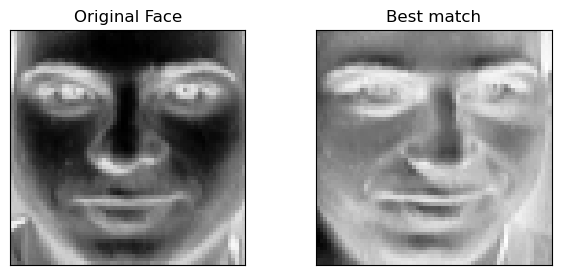

In [11]:
VOLTO_ESEMPIO = 74 #We choose 1 face just as demonstration

fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=2)

axs[0].imshow(X_test[VOLTO_ESEMPIO].reshape(64, 64), cmap='Greys')
axs[0].set_title('Original Face')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(X_train[best_match[VOLTO_ESEMPIO]].reshape(64, 64), cmap='Greys')
axs[1].set_title('Best match')
axs[1].set_xticks([])
axs[1].set_yticks([])